# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
import os
import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from pyspark.sql import Window
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, Evaluator
from pyspark.sql.types import IntegerType, ArrayType, FloatType, DoubleType, Row, DateType
from pyspark.ml.linalg import DenseVector, SparseVector
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


%matplotlib inline

In [3]:
# create a Spark session
spark = SparkSession.builder.master('local[*]').appName("Sparkfy").getOrCreate()
spark

In [4]:
# Check Spark configuration
spark.sparkContext.getConf().getAll()

[('spark.app.startTime', '1673628069022'),
 ('spark.driver.extraJavaOptions',
  '-XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED'),
 ('spark.app.submitTime', '1673628068871'),
 ('spark.app.id', 'local-1673628070314'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir',
  'file:/C:/Users/zanin/OneDrive/Área%20d

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
path = './mini_sparkify_event_data.json'

df = spark.read.json(path)
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string')]

In [7]:
num_rows = df.count()
num_cols = len(df.dtypes)
print(f'The dataframe imported has {num_rows} rows, and {num_cols} columns.')

The dataframe imported has 286500 rows, and 18 columns.


In [8]:
df.toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [9]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

# Dealing with null values 

In [10]:
# Finding Null and NaN values per column 
df\
    .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in df.columns])\
    .show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



So looking for null or nan values we can clarly see that we have patterns on them. Manly 2 amounts of missing values, 58392 for (artist, length and song) columns, and 8346 for (firstName, gender, lastName, location, registration and userAgent) columns.
We can see that for the 8346 represents less than 2% of the smal dataset, so maybe we can drop this values without biggest issues in future. Besides the 58392 represents arround 20% of the data set, so it's better to investigat deep further unders this features. 

In [11]:
df.select('artist', 'length', 'page', 'song', ).where('artist is null').distinct().show(10)


+------+------+--------------------+----+
|artist|length|                page|song|
+------+------+--------------------+----+
|  null|  null|              Cancel|null|
|  null|  null|    Submit Downgrade|null|
|  null|  null|         Thumbs Down|null|
|  null|  null|                Home|null|
|  null|  null|           Downgrade|null|
|  null|  null|         Roll Advert|null|
|  null|  null|              Logout|null|
|  null|  null|       Save Settings|null|
|  null|  null|Cancellation Conf...|null|
|  null|  null|               About|null|
+------+------+--------------------+----+
only showing top 10 rows



In [12]:
df.where(df.page != 'NextSong').select('artist', 'length', 'song').show(5)

+------+------+----+
|artist|length|song|
+------+------+----+
|  null|  null|null|
|  null|  null|null|
|  null|  null|null|
|  null|  null|null|
|  null|  null|null|
+------+------+----+
only showing top 5 rows



As we saw above the columns 'artist', 'length' and 'song' are completly related with each other, if we don't have the song, we don't have the length of the song and we don't have the artist either. So the relation with 'page' seems to be that whenever the user do not click on 'Nextsong', the value on columns 'artist', 'length' and 'song' will be null. Don't look that is missing data or that's an error in data entry, apparently the music was not changed, thus leaving the log with a null value

In [13]:
df.select('userId').distinct().count()

226

In [14]:
df.select('page').distinct().count()

22

In [15]:
df.select('auth').distinct().count()

4

In [16]:
df.select('artist', 'auth', 'length', 'page', 'song', ).where('artist is null').distinct().groupBy('auth').count().show(10)

+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out|    5|
| Cancelled|    1|
|     Guest|    6|
| Logged In|   17|
+----------+-----+



In [17]:
df.where('artist is null').show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null| Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null| Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null| Logged In|    Mi

In [18]:
df.select('userId','gender','level','auth').groupby(['gender','level','auth']).count().show()

+------+-----+----------+------+
|gender|level|      auth| count|
+------+-----+----------+------+
|     F| paid| Logged In|124893|
|     M| paid| Logged In| 97509|
|  null| free|Logged Out|  2520|
|     F| free| Logged In| 29665|
|     M| free| Logged In| 26035|
|  null| paid|Logged Out|  5729|
|     M| paid| Cancelled|    18|
|     F| free| Cancelled|     7|
|     F| paid| Cancelled|    13|
|     M| free| Cancelled|    14|
|  null| free|     Guest|    97|
+------+-----+----------+------+



In [19]:
df.where('firstName is null' and 'lastName is null').show(5)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [20]:
df.where('firstName is null' and df.auth == 'Logged Out').count()

8249

As we can see, whenever firstName and lastName is null, the userId is empty! (not null).

In [21]:
df.select('userId','gender','level','auth', 'method').groupby(['gender','level','auth', 'method']).count().show()

+------+-----+----------+------+------+
|gender|level|      auth|method| count|
+------+-----+----------+------+------+
|     M| paid| Cancelled|   GET|    18|
|  null| free|Logged Out|   PUT|   942|
|     M| paid| Logged In|   PUT| 91875|
|     M| paid| Logged In|   GET|  5634|
|     F| paid| Logged In|   GET|  7015|
|     F| free| Logged In|   GET|  4143|
|  null| paid|Logged Out|   PUT|  2299|
|  null| paid|Logged Out|   GET|  3430|
|  null| free|Logged Out|   GET|  1578|
|     F| free| Logged In|   PUT| 25522|
|     F| paid| Logged In|   PUT|117878|
|     M| free| Logged In|   PUT| 22543|
|     M| free| Logged In|   GET|  3492|
|     F| paid| Cancelled|   GET|    13|
|     F| free| Cancelled|   GET|     7|
|     M| free| Cancelled|   GET|    14|
|  null| free|     Guest|   GET|    92|
|  null| free|     Guest|   PUT|     5|
+------+-----+----------+------+------+



In [22]:
# Changing userId column to Longtype and removing null from userId
df = df.withColumn('userId', f.col('userId').cast(LongType()))
df = df.filter(f.col('userId').isNotNull())

In [23]:
# Removing LoggedOut from column auth.
df = df.filter(f.col('auth')!='LoggedOut')

In [24]:
# taking only the state of location
df = df.withColumn('location', f.split(f.col('location'),',').getItem(1))

In [25]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|      CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|   MA-NH|   PUT|NextSong|1538331630000|        8|              Canada|   200|1538352180000|"Mozilla/

In [26]:
num_rows = df.count()
num_cols = len(df.dtypes)
print(f'The dataframe imported has {num_rows} rows, and {num_cols} columns.')

The dataframe imported has 278154 rows, and 18 columns.


In [27]:
# Finding Null and NaN values per column 
df\
    .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in df.columns])\
    .show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [28]:
# Convert the timestamps in columns 'registration' and 'ts' into datetime format and add them to the dataframe
df = df.withColumn('registrationDate', (df.registration / 1000).cast(TimestampType()))
df = df.withColumn('tsDate', (df.ts / 1000).cast(TimestampType()))

In [29]:
#crating a column of last interaction per user
#df = df.withColumn('lastIteraction', (max(df.tsDate)))
last_interaction_df =  df.groupBy('userId').agg(max('ts').alias('lastIteraction'))
df = last_interaction_df.join(df, on= 'userId', how='left').withColumn('registeredDays', ((f.col('lastIteraction')-f.col('registration'))/86400000).cast(IntegerType()))

In [30]:
df.show(5)

+------+--------------+--------------------+---------+---------+------+-------------+--------+---------+-----+--------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------------------+-------------------+--------------+
|userId|lastIteraction|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|   registrationDate|             tsDate|registeredDays|
+------+--------------+--------------------+---------+---------+------+-------------+--------+---------+-----+--------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------------------+-------------------+--------------+
|    29| 1542181031000|       Blake Shelton|Logged In|    Kaleb|     M|            0|Thompson|246.56934| free|      CA|   PUT|NextSong|1536988041000|       28|Don't M

As observed above whenever gender is null, the auth is Logged Out.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### 1. Pages Analysis and defining churn

In [31]:
df.select('page').distinct().count()

19

In [32]:
pages = df.select('page').groupBy('page').count().orderBy('count', ascending=False).toPandas()
pages.head(25)

,page,count
0,NextSong,228108
1,Thumbs Up,12551
2,Home,10082
3,Add to Playlist,6526
4,Add Friend,4277
5,Roll Advert,3933
6,Logout,3226
7,Thumbs Down,2546
8,Downgrade,2055
9,Settings,1514


Text(0.5, 0, 'Number of interactions')

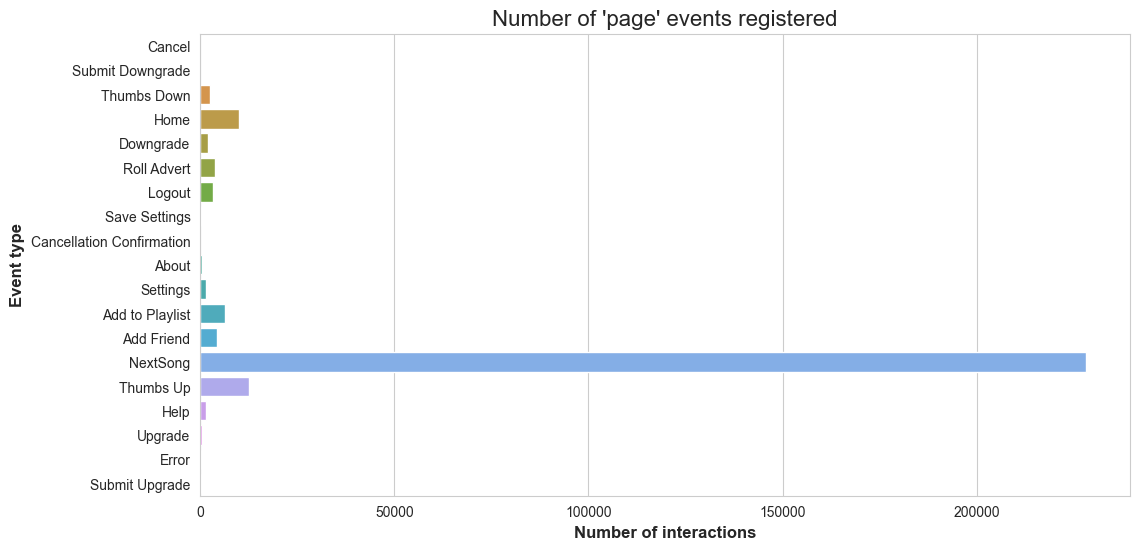

In [33]:
# Number of "page" events registered
data = df.groupby("page").count().alias("count").toPandas()
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x="count", y="page", data=data)
ax.set_title("Number of 'page' events registered", fontsize=16)
ax.set_ylabel("Event type", fontsize=12, weight='bold')
ax.set_xlabel("Number of interactions", fontsize=12, weight='bold')

Text(0.5, 0, 'Number of interactions')

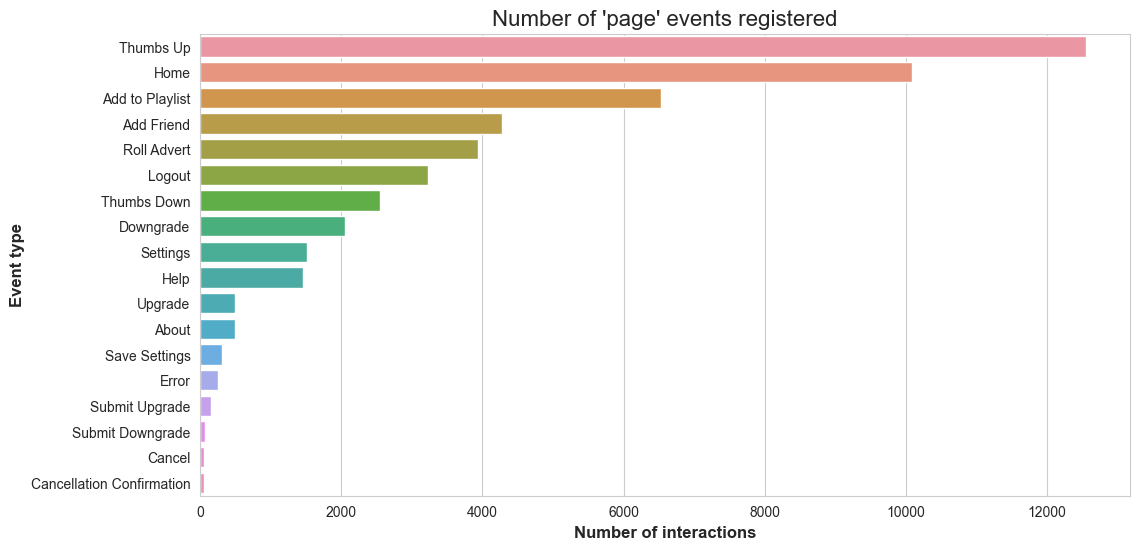

In [34]:
# Number of "page" events registered without 'NextSong'
page_no_nextsong = df.select('page').where(df.page != 'NextSong').groupBy('page').count().orderBy('count', ascending=False).alias('count').toPandas()
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x="count", y="page", data=page_no_nextsong)
ax.set_title("Number of 'page' events registered", fontsize=16)
ax.set_ylabel("Event type", fontsize=12, weight='bold')
ax.set_xlabel("Number of interactions", fontsize=12, weight='bold')

As we can see in page column, the 'NextSong' it'a fareway the page that have biggest interaction with more then 80% of the interactions. And 'Cancel', 'Cancellation Confirmation' and 'Submit Downgrade' shows the lowest actions take by the users and that's what we'll try to predict. Without couting the interaction with 'Nextsong' the actions that users more usualy interact is Thumbs Up (liked a Song), Home, Add to Playlist, add a friend.

### 1.2 Relation of users x interactions with cancelation and downgrade

In [35]:
# Couting the users on this mini_sample of dataset
total_users = df.select('userId').distinct().count()
print(f'The number of users on this sample is {total_users}.')

The number of users on this sample is 225.


In [36]:
df.select('*').where(df.page == 'Cancellation Confirmation').groupBy('level').count().show()

+-----+-----+
|level|count|
+-----+-----+
| paid|   31|
| free|   21|
+-----+-----+



In [37]:
df.select('*').where(df.page == 'Cancellation Confirmation').groupBy('userId').count().show(5)

+------+-----+
|userId|count|
+------+-----+
|    29|    1|
|    54|    1|
|    32|    1|
|   143|    1|
|    87|    1|
+------+-----+
only showing top 5 rows



In [38]:
df.select('*').where(df.page == 'Submit Downgrade').groupBy('level').count().show()

+-----+-----+
|level|count|
+-----+-----+
| paid|   63|
+-----+-----+



In [39]:
# Users that are willing to churn
users_risk_churn = df.where(df.page == 'Submit Downgrade').select('userId').distinct().count()
percentual = 100 * users_risk_churn / total_users

print(f'The users that submited downgrade represent {percentual:.2f}% of the total users of this sample.')



The users that submited downgrade represent 21.78% of the total users of this sample.


In [40]:
df.select('*').where(df.page == 'Downgrade').groupBy('level').count().show()

+-----+-----+
|level|count|
+-----+-----+
| paid| 2055|
+-----+-----+



In [41]:
df.select('*').where(df.page == 'Downgrade').groupBy('userId').count().show()

+------+-----+
|userId|count|
+------+-----+
|    29|   18|
|    65|   20|
|    54|   39|
|   113|   16|
|    77|    9|
|   126|   22|
|    50|    2|
|   136|   21|
|    32|    2|
|    39|   73|
|    98|   25|
|   145|   12|
|    25|   11|
|   124|   41|
|    95|   15|
|     6|   41|
|    87|    1|
|    58|   18|
|     9|   32|
|    51|   23|
+------+-----+
only showing top 20 rows



In [42]:
users_interact_downgrade = df.where(df.page == 'Downgrade').select('userId').distinct().count()
percent = 100 * users_interact_downgrade / total_users

print(f'The users that intreacted with downgrade, represent {percent:.2f}% of the total users of this sample.')


The users that intreacted with downgrade, represent 68.44% of the total users of this sample.


As we can see on the cells above, the percent of users that interacted with Downgrade, is almost 70%!! so this represent a big risk of churns!  

In [43]:
# defining Churn Label data
churned_df = df.withColumn('label', when((col('page').isin(['Cancellation Confirmation','Cancel'])) | (col('auth')=='Cancelled'),1 ).otherwise(0))\
      .groupBy('userId').agg(sum('label').alias('label')).withColumn('label', when(col('label')>=1 ,1).otherwise(0))

df = df.join(churned_df, on='userId')
   

In [44]:
df.count()

278154

In [45]:
# churn by gender
df.select('userId','label').distinct().groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [46]:
df.count()

278154

### 2. Gender analysis

In [47]:
# churn by gender
df.select('userId','gender','label').distinct().groupBy('gender','label').count().show()

+------+-----+-----+
|gender|label|count|
+------+-----+-----+
|     M|    1|   32|
|     F|    0|   84|
|     F|    1|   20|
|     M|    0|   89|
+------+-----+-----+



<AxesSubplot: xlabel='label'>

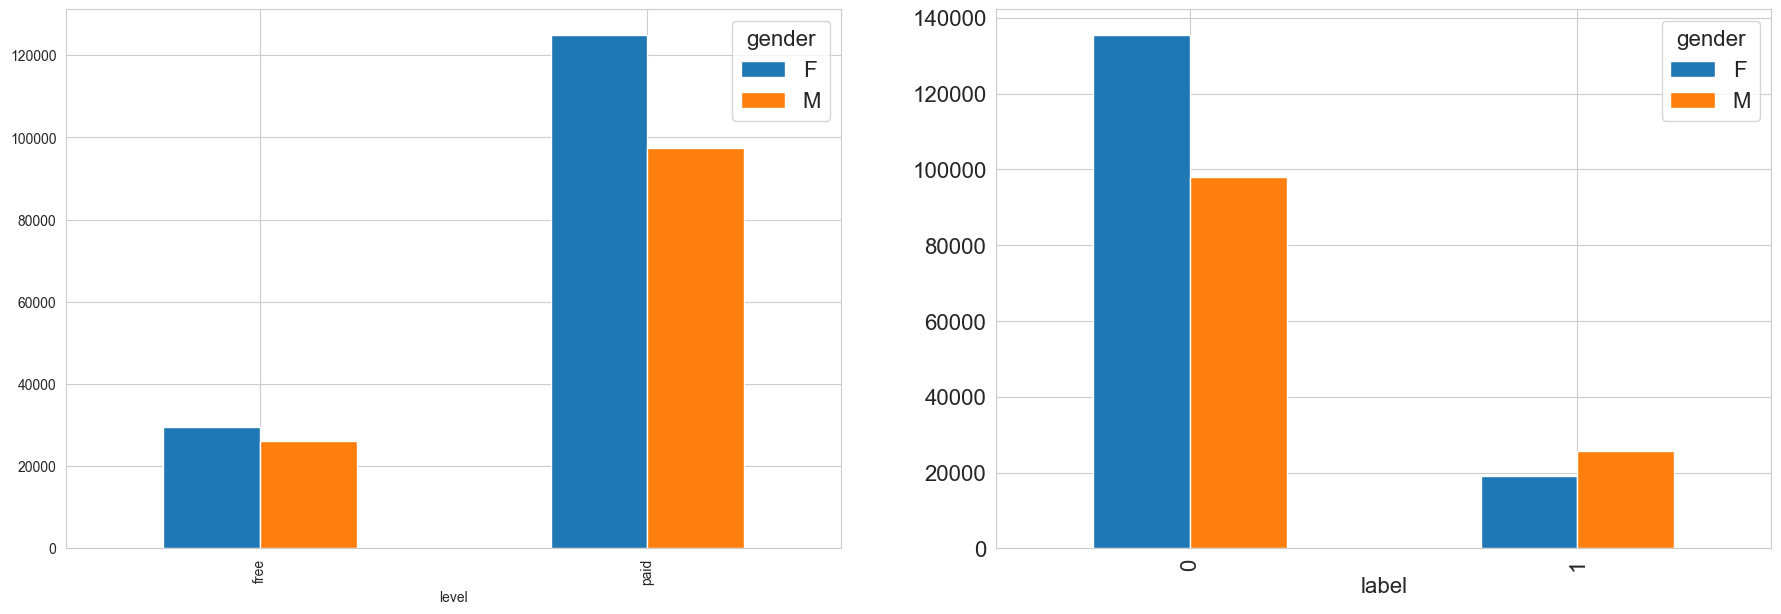

In [48]:
fig = plt.figure(figsize = [22, 7]) 
# relation between gender and free and paid level.
plt.subplot(1, 2, 1)
df_count = df.select('userId','gender','level').groupBy('gender','level').count().toPandas().sort_values(by='count')
ax = fig.gca()
plt.rcParams["font.size"] = "16"
df_count.pivot(index='level', columns='gender', values='count').plot(kind='bar', ax=ax)

# relation between gender and churns
plt.subplot(1, 2, 2)
df_count = df.select('userId','gender','label').groupBy('gender','label').count().toPandas().sort_values(by='count')
ax = fig.gca()
plt.rcParams["font.size"] = "16"
df_count.pivot(index='label', columns='gender', values='count').plot(kind='bar', ax=ax)

### 3. Location

In [49]:
# seeing churn by location
df.select('userId','location','label').distinct().groupBy('location','label').count().show(10)


+---------+-----+-----+
| location|label|count|
+---------+-----+-----+
|       OK|    0|    1|
|    KY-IN|    0|    1|
|       MS|    1|    2|
|       WA|    0|    2|
|       MD|    0|    1|
|       CT|    0|    7|
|    GA-AL|    0|    2|
|       KY|    0|    1|
|       MT|    0|    1|
| IL-IN-WI|    0|    5|
+---------+-----+-----+
only showing top 10 rows



Text(0.5, 0, 'Number of interactions')

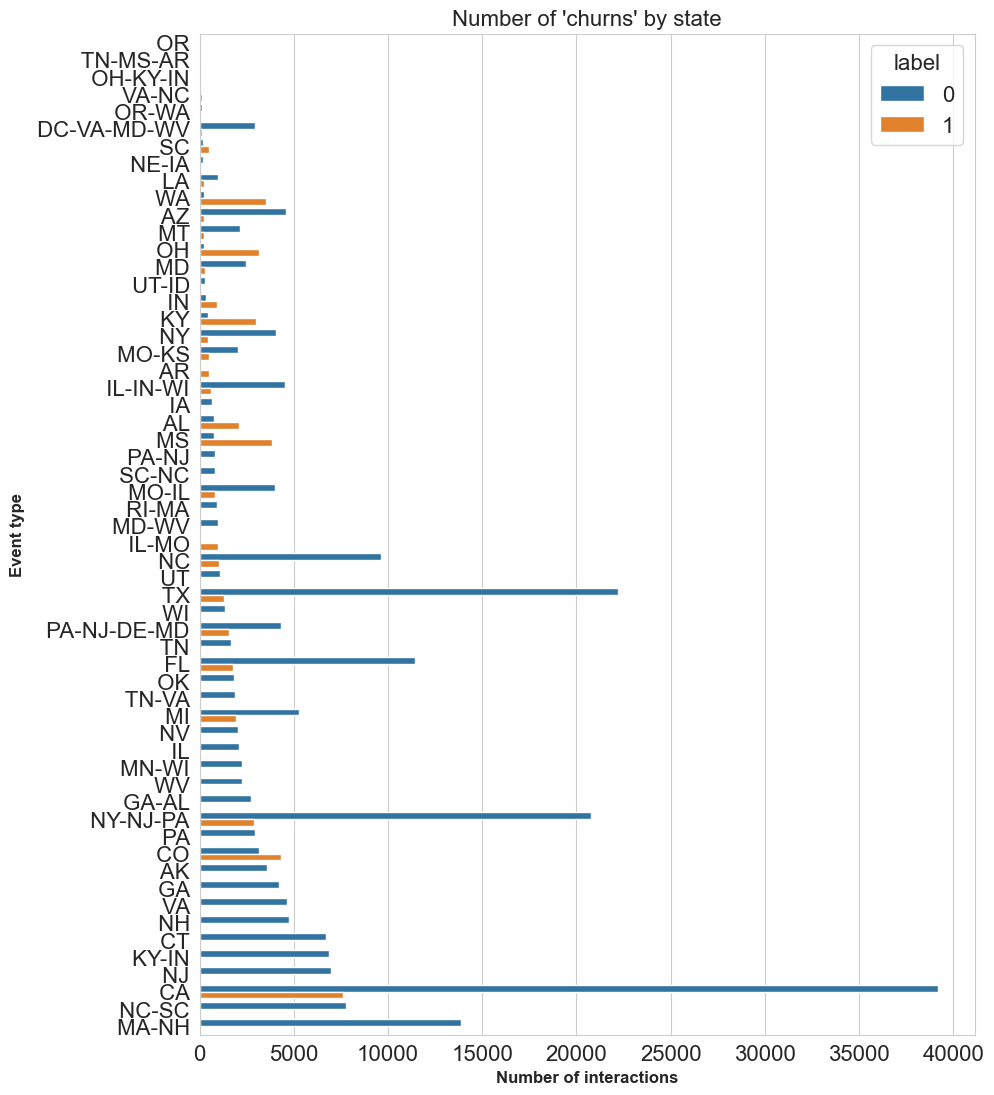

In [50]:
# Number of "page" events registered
data = df.select('userId','location','label').groupby('location','label').count().toPandas().sort_values(by='count')
plt.figure(figsize=(10, 13))
sns.set_style("whitegrid")
ax = sns.barplot(x="count", y="location", hue='label', data=data)
ax.set_title("Number of 'churns' by state", fontsize=16)
ax.set_ylabel("Event type", fontsize=12, weight='bold')
ax.set_xlabel("Number of interactions", fontsize=12, weight='bold')

### 4. Registered days by user

In [51]:
df.select(['userId', 'label', 'registeredDays']).groupBy('label', 'registeredDays').count().show(10)

+-----+--------------+-----+
|label|registeredDays|count|
+-----+--------------+-----+
|    0|           162| 1529|
|    0|            65| 3735|
|    1|            37|  671|
|    1|            59| 1003|
|    0|           152|  977|
|    0|           160|  218|
|    0|           134| 1883|
|    0|            73| 2916|
|    0|           107| 1091|
|    0|            88|  456|
+-----+--------------+-----+
only showing top 10 rows



In [52]:
df.select(['userId', 'label', 'registeredDays']).groupBy('label').avg('registeredDays').show()

+-----+-------------------+
|label|avg(registeredDays)|
+-----+-------------------+
|    1|  67.21311073466477|
|    0|   92.6425736208153|
+-----+-------------------+



In [53]:
df.select(['userId', 'label', 'registeredDays']).groupBy('label').count().show()

+-----+------+
|label| count|
+-----+------+
|    1| 44864|
|    0|233290|
+-----+------+



c:\Users\zanin\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\zanin\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


<Figure size 1800x800 with 0 Axes>

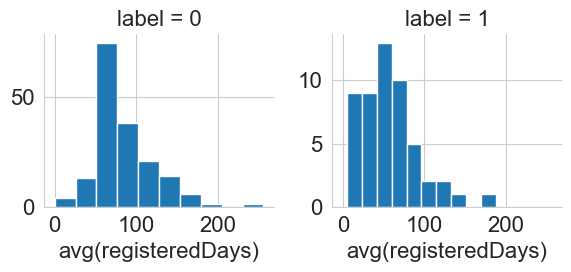

<Figure size 1800x800 with 0 Axes>

In [54]:
register_df = df.groupBy(['userId', 'label']).avg('registeredDays').toPandas()

# comparing two groups of users who label and who don't
g = sns.FacetGrid(register_df, col="label", sharey=False)
g.map(plt.hist, "avg(registeredDays)");
plt.figure(figsize=(18, 8))


### 5. Level

In [55]:
# relation between gender and free and paid level.
df_count = df.select('userId','label','level').groupBy('userId','level').count().toPandas().sort_values(by='count')
ax = fig.gca()
plt.rcParams["font.size"] = "16"
df_count.pivot(index='level', columns='userId', values='count').plot(kind='bar', ax=ax)


<AxesSubplot: xlabel='level'>

In [56]:
#Finds the latest level of each user
level_df = df.orderBy('ts', ascending=False).groupBy('userId').agg(first('level').alias('last_level'))
level_df.show(5)

+------+----------+
|userId|last_level|
+------+----------+
|     2|      paid|
|     3|      paid|
|     4|      paid|
|     5|      free|
|     6|      paid|
+------+----------+
only showing top 5 rows



### 6. length

In [57]:
#Calculates average item length for each user
avg_lenght = df.groupBy('userId').avg('length').orderBy('userId').withColumnRenamed('avg(length)', 'length')
avg_lenght.show(5)

+------+------------------+
|userId|            length|
+------+------------------+
|     2| 249.9170641324505|
|     3|254.32124037383167|
|     4| 247.1386920800777|
|     5|245.49718621118012|
|     6|249.20434428300084|
+------+------------------+
only showing top 5 rows



### 7. SessionId

In [58]:
#Calculates daily average of distinct sessionId for each user
daily_session_df = df.groupby('userId','tsDate').agg(countDistinct('sessionId')).\
groupBy('userId').avg('count(sessionId)').\
withColumnRenamed('avg(count(DISTINCT sessionId))', 'avg_daily_sessions')
daily_session_df.show(2)

+------+---------------------+
|userId|avg(count(sessionId))|
+------+---------------------+
|    29|                  1.0|
|    65|                  1.0|
+------+---------------------+
only showing top 2 rows



### 8. Item Session

In [59]:
#Calculates daily averages for each user,for each item
daily_item_df = df.groupby('userId','tsDate').agg(max('itemInSession')).\
    groupBy('userId').avg('max(itemInSession)').\
    withColumnRenamed('avg(max(itemInSession))', 'avg_daily_items')
    
daily_item_df.show(5)

+------+------------------+
|userId|   avg_daily_items|
+------+------------------+
|    29|153.59504592262732|
|    65|101.34644121116791|
|    54|113.89568764568764|
|   113| 57.14353813559322|
|   112|28.409252669039144|
+------+------------------+
only showing top 5 rows



### 9. Session duration

In [60]:
#Calculates daily average of distinct sessionId for each user
daily_session_duration_df = df.groupby('userId','tsDate','sessionId').\
   agg(max('ts').alias('session_end'), min('ts').alias('session_start')).\
   withColumn('session_duration_sec', (col('session_end')-col('session_start'))*0.001).\
   groupby('userId','tsDate').\
   avg('session_duration_sec').\
   groupby('userId').\
   agg(mean('avg(session_duration_sec)').alias('avg_daily_session_duration')).\
   orderBy('userId', ascending=False)

daily_session_duration_df.show(5)

+------+--------------------------+
|userId|avg_daily_session_duration|
+------+--------------------------+
|300025|                       0.0|
|300024|                       0.0|
|300023|                       0.0|
|300022|                       0.0|
|300021|                       0.0|
+------+--------------------------+
only showing top 5 rows



### 10. page event aggregates 

In [61]:
# Calculates daily averages for each user,for each page event except the ones that include "cancel" 
listOfDistinctPages = [row.page for row in df.select('page').distinct().collect()]
listOfDistinctPages.remove('Cancel')
listOfDistinctPages.remove('Cancellation Confirmation')
    
daily_page_event_df = df.groupby('userId','tsDate').pivot('page').count()
exp_dict={}
for page in listOfDistinctPages:
    exp_dict.update({page:'mean'})

daily_page_event_df = daily_page_event_df.join(daily_page_event_df.groupBy('userId').agg(exp_dict).fillna(0), on='userId')

for page in listOfDistinctPages:
    daily_page_event_df = daily_page_event_df.drop(page)  
    daily_page_event_df = daily_page_event_df.withColumnRenamed('avg({})'.format(page), 'avg_daily_{}'.format(page))

daily_page_event_df = daily_page_event_df.drop('Cancel','Cancellation Confirmation','tsDate').drop_duplicates()
    
daily_page_event_df.show(5)

+------+------------------+--------------------+---------------------+-------------------+------------------------+---------------------+------------------+---------------+---------------+-----------------+-------------------------+--------------+-------------------+----------------+--------------------------+-----------------------+--------------+
|userId|avg_daily_Settings|avg_daily_Add Friend|avg_daily_Thumbs Down|avg_daily_Downgrade|avg_daily_Submit Upgrade|avg_daily_Roll Advert|avg_daily_NextSong|avg_daily_Error|avg_daily_About|avg_daily_Upgrade|avg_daily_Add to Playlist|avg_daily_Home|avg_daily_Thumbs Up|avg_daily_Logout|avg_daily_Submit Downgrade|avg_daily_Save Settings|avg_daily_Help|
+------+------------------+--------------------+---------------------+-------------------+------------------------+---------------------+------------------+---------------+---------------+-----------------+-------------------------+--------------+-------------------+----------------+--------------

In [62]:
daily_page_event_df.count()

225

In [63]:
#Joins all aggregate dataframes and main dataframe for couple of original columns
all_aggs_df =\
    daily_session_duration_df\
    .join(daily_session_df, on= 'userId')\
    .join(level_df, on= 'userId')\
    .join(avg_lenght, on= 'userId')\
    .join(daily_item_df, on='userId')\
    .join(daily_page_event_df, on='userId')

    # auth is dropped as it has single value 'Logged In' after initial cleanup
    # date, ts, interaction time, registration are removed as these are not relevant when one row
    # for user is left and these have been used for aggregation, the information is hidden in agg features
    # page, length, sessionId, itemInsession have been removed as these have been used for aggregations
    # artist, song, method, status, userAgent have been removed to avoid complexity
    # firstName, lastName has been removed as they're redundant.user id sufficient to identify customer
df = df.drop('auth', 'level','length','userAgent','tsDate','interaction_time','registration', 'ts','song','page','itemInSession','sessionId','artist','firstName','lastName','method','status')
joined_df = all_aggs_df.join(df, on='userId')
    
joined_df = joined_df.drop_duplicates()
features_df = joined_df.drop('userId', 'tsDate', 'registrationDate')


In [64]:
df.show(3)

+------+--------------+------+--------+-------------------+--------------+-----+
|userId|lastIteraction|gender|location|   registrationDate|registeredDays|label|
+------+--------------+------+--------+-------------------+--------------+-----+
|     2| 1542839404000|     F|      NC|2018-09-13 02:49:30|            69|    0|
|     2| 1542839404000|     F|      NC|2018-09-13 02:49:30|            69|    0|
|     2| 1542839404000|     F|      NC|2018-09-13 02:49:30|            69|    0|
+------+--------------+------+--------+-------------------+--------------+-----+
only showing top 3 rows



In [65]:
all_aggs_df.show(3)

+------+--------------------------+---------------------+----------+------------------+------------------+------------------+--------------------+---------------------+-------------------+------------------------+---------------------+------------------+---------------+---------------+-----------------+-------------------------+--------------+-------------------+----------------+--------------------------+-----------------------+--------------+
|userId|avg_daily_session_duration|avg(count(sessionId))|last_level|            length|   avg_daily_items|avg_daily_Settings|avg_daily_Add Friend|avg_daily_Thumbs Down|avg_daily_Downgrade|avg_daily_Submit Upgrade|avg_daily_Roll Advert|avg_daily_NextSong|avg_daily_Error|avg_daily_About|avg_daily_Upgrade|avg_daily_Add to Playlist|avg_daily_Home|avg_daily_Thumbs Up|avg_daily_Logout|avg_daily_Submit Downgrade|avg_daily_Save Settings|avg_daily_Help|
+------+--------------------------+---------------------+----------+------------------+---------------

In [66]:
joined_df = all_aggs_df.join(df, on='userId')
joined_df.show(2)

+------+--------------------------+---------------------+----------+------------------+-----------------+------------------+--------------------+---------------------+-------------------+------------------------+---------------------+------------------+---------------+---------------+-----------------+-------------------------+--------------+-------------------+----------------+--------------------------+-----------------------+--------------+--------------+------+--------+-------------------+--------------+-----+
|userId|avg_daily_session_duration|avg(count(sessionId))|last_level|            length|  avg_daily_items|avg_daily_Settings|avg_daily_Add Friend|avg_daily_Thumbs Down|avg_daily_Downgrade|avg_daily_Submit Upgrade|avg_daily_Roll Advert|avg_daily_NextSong|avg_daily_Error|avg_daily_About|avg_daily_Upgrade|avg_daily_Add to Playlist|avg_daily_Home|avg_daily_Thumbs Up|avg_daily_Logout|avg_daily_Submit Downgrade|avg_daily_Save Settings|avg_daily_Help|lastIteraction|gender|location|  

In [67]:
features_df.printSchema()

root
 |-- avg_daily_session_duration: double (nullable = true)
 |-- avg(count(sessionId)): double (nullable = true)
 |-- last_level: string (nullable = true)
 |-- length: double (nullable = true)
 |-- avg_daily_items: double (nullable = true)
 |-- avg_daily_Settings: double (nullable = false)
 |-- avg_daily_Add Friend: double (nullable = false)
 |-- avg_daily_Thumbs Down: double (nullable = false)
 |-- avg_daily_Downgrade: double (nullable = false)
 |-- avg_daily_Submit Upgrade: double (nullable = false)
 |-- avg_daily_Roll Advert: double (nullable = false)
 |-- avg_daily_NextSong: double (nullable = false)
 |-- avg_daily_Error: double (nullable = false)
 |-- avg_daily_About: double (nullable = false)
 |-- avg_daily_Upgrade: double (nullable = false)
 |-- avg_daily_Add to Playlist: double (nullable = false)
 |-- avg_daily_Home: double (nullable = false)
 |-- avg_daily_Thumbs Up: double (nullable = false)
 |-- avg_daily_Logout: double (nullable = false)
 |-- avg_daily_Submit Downgrade: 

In [68]:
features_df_pd = features_df.toPandas()

In [69]:
num_rows = features_df.count()
num_cols = len(features_df.dtypes)
print(f'The dataframe imported has {num_rows} rows, and {num_cols} columns.')

The dataframe imported has 225 rows, and 27 columns.


In [70]:
#Packing Numeric features together with VectorAssembler
num_cols = []
    
for field in features_df.schema.fields :
    if field.dataType!=StringType():
        num_cols.append(field.name)

num_cols.remove('label')
assembler = VectorAssembler(inputCols=num_cols, outputCol='features')
print(num_cols)

['avg_daily_session_duration', 'avg(count(sessionId))', 'length', 'avg_daily_items', 'avg_daily_Settings', 'avg_daily_Add Friend', 'avg_daily_Thumbs Down', 'avg_daily_Downgrade', 'avg_daily_Submit Upgrade', 'avg_daily_Roll Advert', 'avg_daily_NextSong', 'avg_daily_Error', 'avg_daily_About', 'avg_daily_Upgrade', 'avg_daily_Add to Playlist', 'avg_daily_Home', 'avg_daily_Thumbs Up', 'avg_daily_Logout', 'avg_daily_Submit Downgrade', 'avg_daily_Save Settings', 'avg_daily_Help', 'lastIteraction', 'registeredDays']


In [71]:
#Text Processing with StringIndexer
indexer_gender = StringIndexer(inputCol='gender', outputCol='gender_index')
indexer_location = StringIndexer(inputCol='location', outputCol='location_index')
indexer_last_level = StringIndexer(inputCol='last_level', outputCol='last_level_index')

#assembler = VectorAssembler(inputCols=num_cols, outputCol='features')

process_pipeline = Pipeline(stages=[indexer_gender, indexer_location, indexer_last_level, assembler])

In [72]:
# Split the data into training (plus validation) and test set 

train, test = features_df.randomSplit([0.8, 0.2], seed = 9) 
ntotal = features_df.count()
ntrainval = train.count()
ntest = test.count()

print(f'Original dataset: {ntotal} rows. Training and validation: {ntrainval} rows. Testing set: {ntest} rows')

Original dataset: 225 rows. Training and validation: 173 rows. Testing set: 52 rows


In [73]:
#Training Logistic Regression Classifier 
lrc = LogisticRegression()
pipeline_lrc = Pipeline(stages=[indexer_gender, indexer_location, indexer_last_level, assembler, lrc])

#Fiting  and training data set 
model_lrc = pipeline_lrc.fit(train)

#evaluation obtaining predictions on test data set
results_lrc = model_lrc.transform(test)

# F1 score on the test set
f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
f1_score = f1_score_evaluator.evaluate(results_lrc.select(col('label'), col('prediction')))
print(f'The F1 score on Logistic Regression model is: {f1_score:.2%}') 

# AUC score on the test set    
auc_evaluator = BinaryClassificationEvaluator()
metric_value = auc_evaluator.evaluate(results_lrc, {auc_evaluator.metricName: "areaUnderROC"})
print(f'The areaUnderROC on Logistic Regression model is: {metric_value:.2%}')

The F1 score on Logistic Regression model is: 84.03%
The areaUnderROC on Logistic Regression model is: 80.04%


In [74]:
# Training Random Forest Classifier
rfc = RandomForestClassifier()
pipeline_rfc = Pipeline(stages=[indexer_gender, indexer_location, indexer_last_level, assembler, rfc])

# Fit and calculate predictions
model_rfc = pipeline_rfc.fit(train)

#evaluation obtaining predictions on test data set
results_rfc = model_rfc.transform(test)


# F1 score on the test set
f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
f1_score = f1_score_evaluator.evaluate(results_rfc.select(col('label'), col('prediction')))
print(f'The F1 score on Random Forest Classifier model is: {f1_score:.2%}') 

# AUC score on the test set    
auc_evaluator = BinaryClassificationEvaluator()
metric_value = auc_evaluator.evaluate(results_rfc, {auc_evaluator.metricName: "areaUnderROC"})
print(f'The areaUnderROC on Random Forest Classifier model is: {metric_value:.2%}')

The F1 score on Random Forest Classifier model is: 86.69%
The areaUnderROC on Random Forest Classifier model is: 88.03%


In [75]:
# Training Gradient Boost Classifier
gtb = GBTClassifier()
pipeline_gtb = Pipeline(stages=[indexer_gender, indexer_location, indexer_last_level, assembler, gtb])

# Fit and calculate predictions
model_gtb = pipeline_gtb.fit(train)

#evaluation obtaining predictions on test data set
results_gtb = model_gtb.transform(test)


# F1 score on the test set
f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
f1_score = f1_score_evaluator.evaluate(results_gtb.select(col('label'), col('prediction')))
print(f'The F1 score on Gradient Boost Classifier model is: {f1_score:.2%}') 

# AUC score on the test set    
auc_evaluator = BinaryClassificationEvaluator()
metric_value = auc_evaluator.evaluate(results_gtb, {auc_evaluator.metricName: "areaUnderROC"})
print(f'The areaUnderROC on Gradient Boost Classifier model is: {metric_value:.2%}')

The F1 score on Gradient Boost Classifier model is: 82.38%
The areaUnderROC on Gradient Boost Classifier model is: 78.16%


In [81]:
#tuning Random Forest Classifier
tuned_rfc = RandomForestClassifier()
pipeline_tuned_rfc = Pipeline(stages=[indexer_gender, indexer_location, indexer_last_level, assembler, tuned_rfc])

rfc_param_grid = ParamGridBuilder()\
                .addGrid(tuned_rfc.numTrees, [20,75])\
                .addGrid(tuned_rfc.maxDepth, [10,20])\
                .build()

crossvalidator_rfc = CrossValidator(estimator = pipeline_rfc,
                         estimatorParamMaps = rfc_param_grid,
                         evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                         numFolds = 3)

rfc_cv_model = crossvalidator_rfc.fit(train)
rfc_cv_results = rfc_cv_model.transform(test)


Py4JJavaError: An error occurred while calling o5147.evaluate.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 25 in stage 4365.0 failed 1 times, most recent failure: Lost task 25.0 in stage 4365.0 (TID 30881) (Thales-PC executor driver): org.apache.spark.memory.SparkOutOfMemoryError: Unable to acquire 65536 bytes of memory, got 0
	at org.apache.spark.memory.MemoryConsumer.throwOom(MemoryConsumer.java:158)
	at org.apache.spark.memory.MemoryConsumer.allocateArray(MemoryConsumer.java:97)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.growPointerArrayIfNecessary(UnsafeExternalSorter.java:413)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.allocateMemoryForRecordIfNecessary(UnsafeExternalSorter.java:447)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertRecord(UnsafeExternalSorter.java:485)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.insertRow(UnsafeExternalRowSorter.java:138)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage64.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage64.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage65.smj_findNextJoinRows_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage65.hashAgg_doAggregateWithKeys_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage65.hashAgg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage65.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage65.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:779)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage66.smj_findNextJoinRows_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage66.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:779)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage67.smj_findNextJoinRows_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage67.hashAgg_doAggregateWithKeys_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage67.hashAgg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage67.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage67.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:779)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.hasNext(InMemoryRelation.scala:118)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1518)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1445)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1509)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1332)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:376)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:327)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.sql.execution.SQLExecutionRDD.$anonfun$compute$1(SQLExecutionRDD.scala:52)
	at org.apache.spark.sql.internal.SQLConf$.withExistingConf(SQLConf.scala:158)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1589)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2293)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1021)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1020)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:738)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:737)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusions$lzycompute(MulticlassMetrics.scala:61)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusions(MulticlassMetrics.scala:52)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.labelCountByClass$lzycompute(MulticlassMetrics.scala:66)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.labelCountByClass(MulticlassMetrics.scala:64)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.weightedFMeasure(MulticlassMetrics.scala:227)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.weightedFMeasure$lzycompute(MulticlassMetrics.scala:235)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.weightedFMeasure(MulticlassMetrics.scala:235)
	at org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator.evaluate(MulticlassClassificationEvaluator.scala:153)
	at java.base/jdk.internal.reflect.DirectMethodHandleAccessor.invoke(DirectMethodHandleAccessor.java:104)
	at java.base/java.lang.reflect.Method.invoke(Method.java:578)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1589)
Caused by: org.apache.spark.memory.SparkOutOfMemoryError: Unable to acquire 65536 bytes of memory, got 0
	at org.apache.spark.memory.MemoryConsumer.throwOom(MemoryConsumer.java:158)
	at org.apache.spark.memory.MemoryConsumer.allocateArray(MemoryConsumer.java:97)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.growPointerArrayIfNecessary(UnsafeExternalSorter.java:413)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.allocateMemoryForRecordIfNecessary(UnsafeExternalSorter.java:447)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertRecord(UnsafeExternalSorter.java:485)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.insertRow(UnsafeExternalRowSorter.java:138)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage64.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage64.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage65.smj_findNextJoinRows_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage65.hashAgg_doAggregateWithKeys_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage65.hashAgg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage65.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage65.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:779)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage66.smj_findNextJoinRows_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage66.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:779)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage67.smj_findNextJoinRows_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage67.hashAgg_doAggregateWithKeys_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage67.hashAgg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage67.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage67.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:779)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.hasNext(InMemoryRelation.scala:118)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1518)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1445)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1509)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1332)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:376)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:327)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.sql.execution.SQLExecutionRDD.$anonfun$compute$1(SQLExecutionRDD.scala:52)
	at org.apache.spark.sql.internal.SQLConf$.withExistingConf(SQLConf.scala:158)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more


In [ ]:

# F1 score on the test set
f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
f1_score = f1_score_evaluator.evaluate(rfc_cv_results.select(col('label'), col('prediction')))
print(f'The F1 score on Gradient Boost Classifier model is: {f1_score:.2%}') 

# AUC score on the test set    
auc_evaluator = BinaryClassificationEvaluator()
metric_value = auc_evaluator.evaluate(rfc_cv_results, {auc_evaluator.metricName: "areaUnderROC"})
print(f'The areaUnderROC on Gradient Boost Classifier model is: {metric_value:.2%}')

bestPipeline = rfc_cv_model.bestModel

print(f'Best parameters : max depth:{bestPipeline.stages[0].getOrDefaultmaxDepth}, num Trees:{ bestPipeline.stages[0].getNumTrees}')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.